## Libraries

We are going to import all the necessary libraries to build our models

First we are going to create a Neuronal network with tensorboard and then a machine learning model with sklearn to compare our prediction results!

List of libraries we are going to use:

* Pandas: Import our dataset
* joblib: Export our scaller
* sklearn: Machine learning models such as Naive Bayes, SVC, Decission Tree
* numpy: Use it to create numpy arrays to our new exported model
* tensorflow & Keras: Our mathematicals libraries to create Neuronal Networks


In [4]:
import pandas as pd

import joblib

import numpy as np
import datetime
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout

# Importing seaborn, pyplot and plotly
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)


In [5]:
# Checking if we are using tensorflow 2.x
tf.__version__

'2.6.0'

## Datasets and Inputs

We are going to use the Diabetes Kaggle dataset to achieve this project https://www.kaggle.com/uciml/pima-indians-diabetes-database. In this dataset all patients here are females at least 21 years old of Pima Indian heritage.
This data has many medical predictors as independent variables and one dependent variable.


### **Variables:**
* **Pregnancies:** Number of times pregnant
* **Glucose:** Plasma glucose concentration 2 hours in an oral glucose tolerance test.
* **BloodPressure:** Diastolic blood pressure (mm Hg)
* **SkinThickness:** Triceps skin fold thickness (mm)
* **Insulin:** 2-Hour serum insulin (mu U/ml)
* **BMI:** Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction:** Diabetes pedigree function
* **Outcome:** Is diabetic person or not

In [6]:
# Loading our dataset
df = pd.read_csv('./diabetes.csv')

In [7]:
# Showing of first 5 rows in our dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
def dataset_count():
    trace = go.Bar(x = df['Outcome'].value_counts().values.tolist(), y = ['healthy','diabetic' ], orientation = 'h', text=df['Outcome'].value_counts().values.tolist(), 
        textfont=dict(size=15), textposition = 'auto', opacity = 0.8,marker=dict(color=['lightskyblue', 'gold']))

    layout = dict(title =  'Outcome count')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

dataset_count()

We can see a clear unbalance in the dataset where we have more healthy people than diabetics.

## Missing values

We can see that there a 0 on the insulin and SkinThickness, which doesn't make sense. Let's replace all the 0 for NaN where a 0 doesn't make sense ('Glucose','BloodPressure','SkinThickness','Insulin','BMI').

In [9]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

We see that we have some missing values

## Replacing missing values

Let's use the mean to replace them depending on the outcome.

In [10]:
# helper function to retrieve the median based on the outcome
def target_median(var):   
    tmp = df[df[var].notnull()]
    tmp = tmp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return tmp

### Insulin

In [11]:
target_median('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


Insulin's target medians are different, that's why we need to do it depending on the outcome.

In [12]:
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] = 102.5
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = 169.5

### Glucose

In [13]:
target_median('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In this case we can see that 107.0 is the median value of a healthy person and 140.0 for a diabetic person

In [14]:
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = 107
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = 140

### SkinThickness

In [15]:
target_median('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In this case is not a huge diference but is preferable to have a value different from 0. 27 is for a healthy person and 32 for a diabetic person

In [16]:
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 27
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 32

### BloodPressure

In [17]:
target_median('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [18]:
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 70
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

### BMI (Body mass Index)

In [19]:
target_median('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [20]:
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = 30.1
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = 34.3

Now Let's check if we get rid of all the missing values

In [21]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Now all the features have values!

## Observations

As you can see, we have 8 independient variables (Pregnancies, Glucose, Blood Pressure, Insulin, BMI, Diabetes pedigree Function, Age) and 1 dependient variable (Outcome)


Before splitting our dataset i would like to see if there is a strong correlation between them and plot them!

In [22]:
# Showing a table with correlations
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.130155,0.209151,0.089028,0.058767,0.023890,-0.033523,0.544341,0.221898
Glucose,0.130155,1.000000,0.225141,0.229289,0.490015,0.236171,0.138353,0.268910,0.495990
BloodPressure,0.209151,0.225141,1.000000,0.199349,0.070128,0.286399,-0.001443,0.325135,0.174469
SkinThickness,0.089028,0.229289,0.199349,1.000000,0.200129,0.566086,0.106280,0.129537,0.295138
Insulin,0.058767,0.490015,0.070128,0.200129,1.000000,0.238443,0.146878,0.123629,0.377081
BMI,0.023890,0.236171,0.286399,0.566086,0.238443,1.000000,0.152771,0.027849,0.315577
DiabetesPedigreeFunction,-0.033523,0.138353,-0.001443,0.106280,0.146878,0.152771,1.000000,0.033561,0.173844
Age,0.544341,0.268910,0.325135,0.129537,0.123629,0.027849,0.033561,1.000000,0.238356
Outcome,0.221898,0.495990,0.174469,0.295138,0.377081,0.315577,0.173844,0.238356,1.000000


### Sometimes it is very hard to see the correlations between all variables, but we can use matplotlib and seaborn to see a better picture of our variables

In [23]:
# Importing seaborn, pyplot and plotly

import seaborn as sns
import matplotlib.pyplot as plt
py.init_notebook_mode(connected=True)

In [24]:
# Get nicer graphs!
sns.set()

We are going to see a big picture of our variables to get a visual understanding

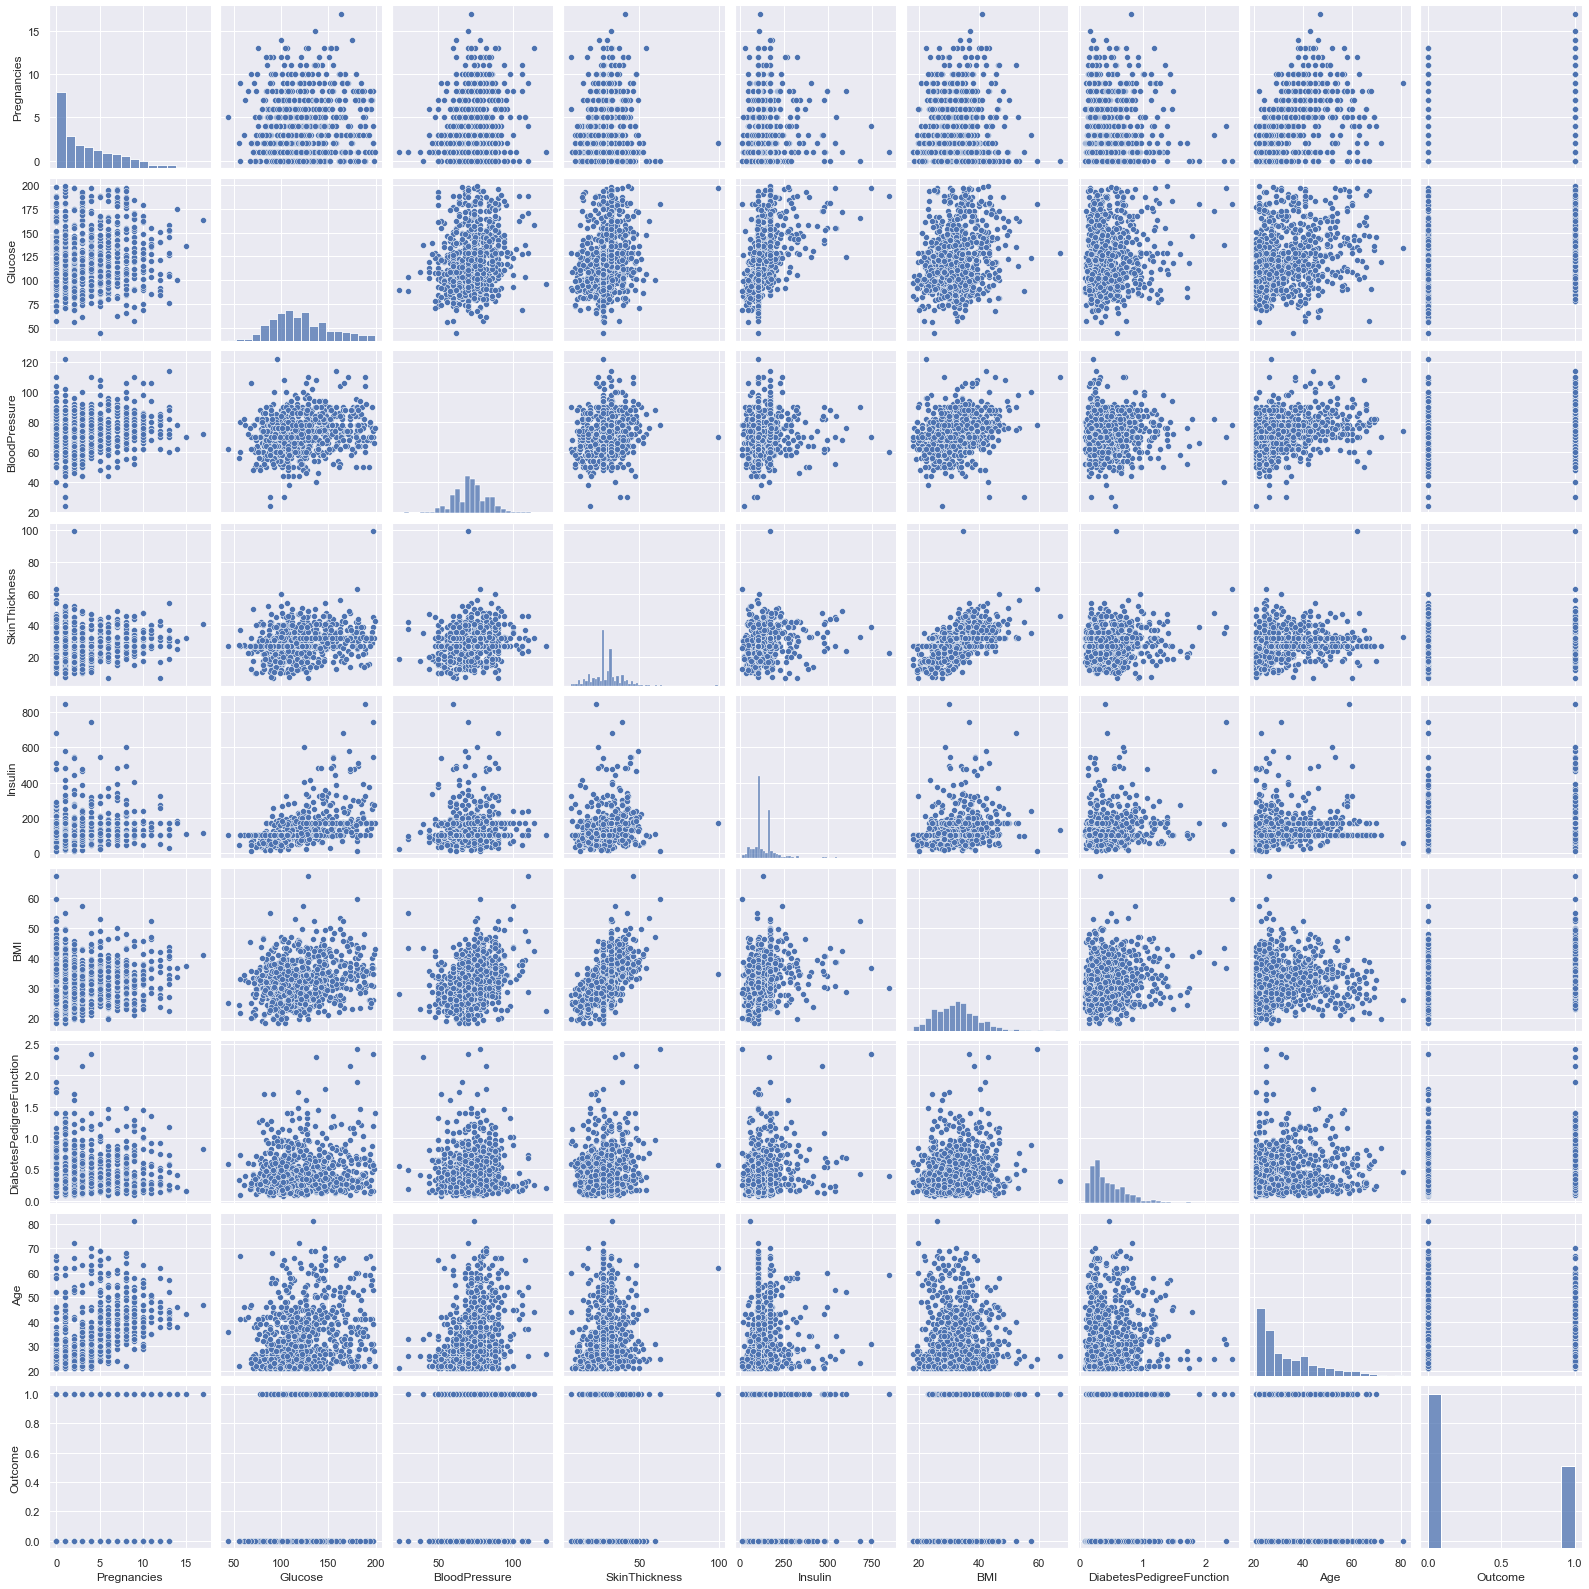

In [25]:
sns.pairplot(df, height=2.5)

Better!. With this, we can understand visually if two variable has a strong correlations or not.

As you can see The Insuline and Glucose seems like has a correlations, we are going to plot it to see what happens

<AxesSubplot:xlabel='Insulin', ylabel='Glucose'>

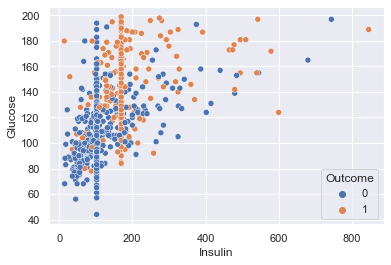

In [26]:
sns.scatterplot(x='Insulin', y='Glucose', data=df, hue='Outcome')

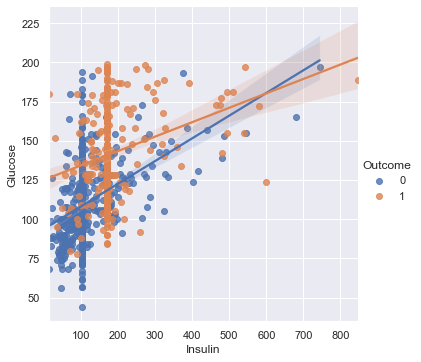

In [27]:
sns.lmplot(x='Insulin', y='Glucose', data=df, hue='Outcome')

As you can see there is a strong relation between de Insulin and Glucose, and have sense because the diabetic people that stink insulin has glocuse level very high!


### Let's see a heatmap to get a better understand of the correlation

<AxesSubplot:>

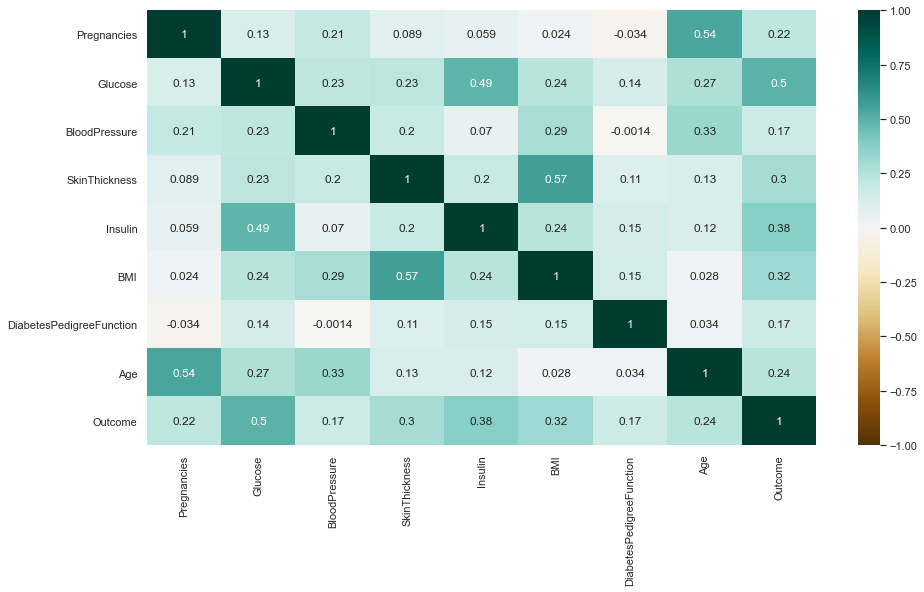

In [28]:
plt.subplots(figsize=(15, 8))

sns.heatmap(df.corr(), annot=True, cmap='BrBG', vmin=-1, vmax=1)


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

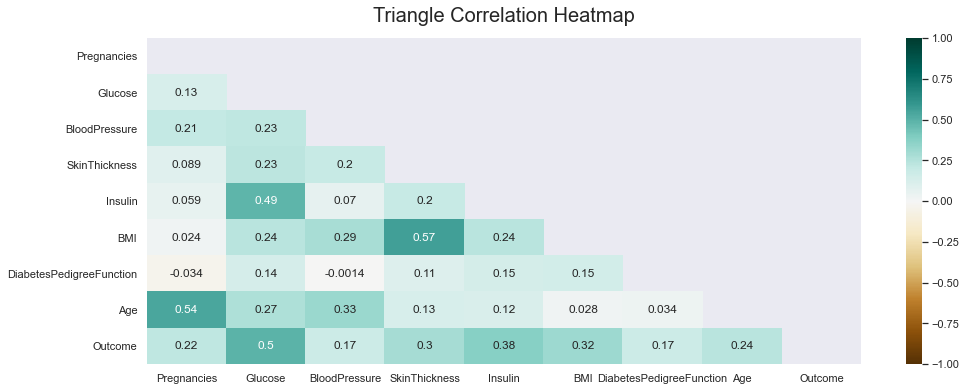

In [29]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap',
                  fontdict={'fontsize': 20}, pad=16)

There is a strong relation between Skin thickness and Insulin and make sense, we can say that people with heigh Skin thickness will have high levels of Insuline.

<AxesSubplot:xlabel='Insulin', ylabel='SkinThickness'>

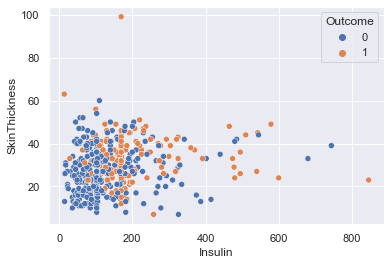

In [30]:
sns.scatterplot(x='Insulin', y='SkinThickness', data=df, hue='Outcome')

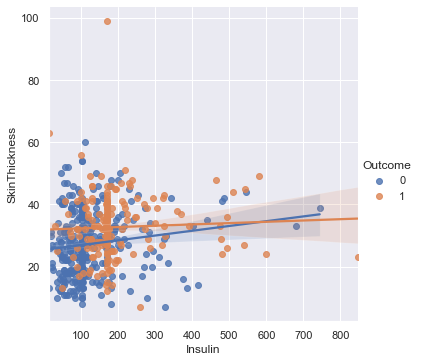

In [31]:
sns.lmplot(x='Insulin', y='SkinThickness', data=df, hue='Outcome')

## Splitting data

We are going to split our dataset into training set (80%) and test set (20%)!

In [32]:
x = df.iloc[:, 0:8].values
y = df.iloc[:, -1].values

In [33]:
pd.DataFrame(x).head()

,0,1,2,3,4,5,6,7
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0


In [34]:
pd.DataFrame(y).head()

,0
0,1
1,0
2,1
3,0
4,1


In [35]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1)

In [36]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7
0,9.0,145.0,80.0,46.0,130.0,37.9,0.637,40.0
1,10.0,129.0,62.0,36.0,169.5,41.2,0.441,38.0
2,7.0,102.0,74.0,40.0,105.0,37.2,0.204,45.0
3,8.0,120.0,78.0,27.0,102.5,25.0,0.409,64.0
4,2.0,120.0,76.0,37.0,105.0,39.7,0.215,29.0
...,...,...,...,...,...,...,...,...
609,2.0,157.0,74.0,35.0,440.0,39.4,0.134,30.0
610,7.0,187.0,50.0,33.0,392.0,33.9,0.826,34.0
611,13.0,126.0,90.0,32.0,169.5,43.4,0.583,42.0
612,4.0,171.0,72.0,32.0,169.5,43.6,0.479,26.0


To get better results we are going to scale our data!

In [37]:
# Feature Scaling

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7
0,1.516591,0.761557,0.621981,1.975874,-0.134534,0.837518,0.529526,0.567932
1,1.812018,0.236795,-0.827800,0.825607,0.303844,1.321483,-0.069689,0.398450
2,0.925736,-0.648741,0.138721,1.285714,-0.411988,0.734858,-0.794249,0.991638
3,1.221164,-0.058384,0.460894,-0.209633,-0.439733,-1.054349,-0.167519,2.601722
4,-0.551400,-0.058384,0.299808,0.940634,-0.411988,1.101499,-0.760619,-0.364222
...,...,...,...,...,...,...,...,...
609,-0.551400,1.155128,0.138721,0.710580,3.305897,1.057502,-1.008254,-0.279481
610,0.925736,2.139057,-1.794320,0.480527,2.773185,0.250892,1.107339,0.059484
611,2.698300,0.138402,1.427415,0.365500,0.303844,1.644127,0.364436,0.737415
612,0.039454,1.614295,-0.022366,0.365500,0.303844,1.673459,0.046486,-0.618446


In [38]:
# Tensorflow Neuronal Network

units = 35
drop = 0.3

# Initializing ANN
classifier = Sequential()



# Input layer of inputs nodes
classifier.add(
    Dense(units=units, kernel_initializer="uniform",
          activation="relu", input_dim=8)
)
classifier.add(Dropout(rate=drop))
classifier.add(
    Dense(units=units, kernel_initializer="uniform", activation="relu"))
classifier.add(Dropout(rate=drop))
classifier.add(
    Dense(units=units, kernel_initializer="uniform", activation="relu"))
classifier.add(Dropout(rate=drop))
classifier.add(
    Dense(units=units, kernel_initializer="uniform", activation="relu"))
classifier.add(Dropout(rate=drop))
classifier.add(
    Dense(units=units, kernel_initializer="uniform", activation="relu"))
classifier.add(Dropout(rate=drop))
classifier.add(
    Dense(units=1, kernel_initializer="uniform", activation="sigmoid"))


classifier.compile(optimizer="adamax",
                   loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = classifier.fit(x_train, y_train, batch_size=10, epochs=350)



Epoch 1/350
62/62 [==============================] - 4s 4ms/step - loss: 0.6916 - accuracy: 0.6124 - precision: 0.4000 - recall: 0.2347
Epoch 2/350
62/62 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6531 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/350
62/62 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.6531 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/350
62/62 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6531 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/350
62/62 [==============================] - 0s 4ms/step - loss: 0.5531 - accuracy: 0.6531 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/350
62/62 [==============================] - 0s 4ms/step - loss: 0.5030 - accuracy: 0.6531 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/350
62/62 [==============================] - 0s 4ms/step - loss: 0.4901 - accuracy: 0.6531 - precision: 0.0000e+00 - recall: 0.0000e+00


Text(0, 0.5, 'Loss')

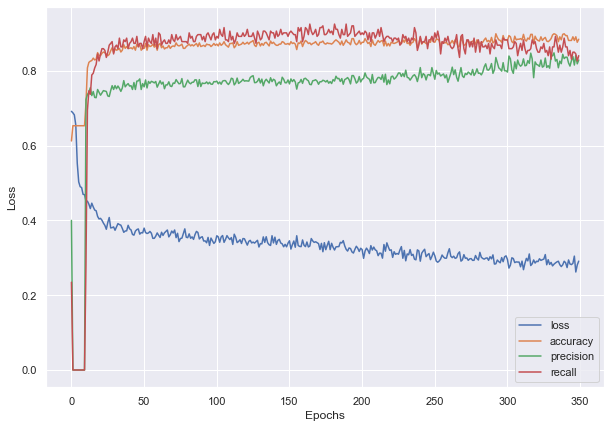

In [39]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('Epochs')
plt.ylabel('Loss')

**bold text**## Nice :D!, we got an accuracy around 89%!, Let's see the summary and the report!

In [40]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                315       
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                1260      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 35)                1260      
_________________________________________________________________
dropout_2 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 35)                1

pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('Epochs')
plt.ylabel('Loss')


It is very important to save your Tensorflow model into a file to import it later. For example you have a Flask python backend using Docker and just import your model and use it in the endpoint!


Also dump your scaler model to always scale with the same values your new input prediction values!

In [41]:
classifier.save("./diabetes_deep_learning_model.hd5")
joblib.dump(sc, "./std_scaler.bin", compress=True)
y_pred = classifier.predict(x_test)

INFO:tensorflow:Assets written to: ./diabetes_deep_learning_model.hd5\assets


In [42]:
y_pred

array([[3.80659997e-01],
       [2.83378065e-02],
       [1.15640461e-02],
       [3.14202905e-03],
       [5.98723829e-01],
       [5.96251786e-02],
       [7.97124803e-02],
       [7.00983405e-03],
       [4.13535833e-02],
       [7.52293885e-01],
       [1.22312427e-01],
       [4.25809324e-02],
       [6.92746937e-02],
       [9.01896775e-01],
       [1.00477070e-01],
       [9.07699883e-01],
       [7.24403560e-02],
       [1.42719150e-02],
       [4.56005335e-04],
       [6.16666675e-02],
       [1.44922882e-01],
       [1.03537709e-01],
       [8.09107542e-01],
       [8.79014254e-01],
       [9.13393497e-03],
       [1.54946446e-02],
       [7.60714233e-01],
       [9.02329564e-01],
       [1.03478432e-02],
       [8.94838095e-01],
       [8.67966652e-01],
       [2.75418162e-02],
       [9.21922922e-03],
       [4.11418766e-01],
       [8.65219831e-02],
       [8.68681192e-01],
       [2.32660174e-02],
       [8.84358883e-02],
       [3.63162160e-03],
       [1.86556846e-01],


We can say that the new prediction grather than 0.5 is Positive and less than 0.5 is Negative!

In [43]:
y_pred_prod = classifier.predict(x_test)
y_pred = (y_pred > 0.5)

In [44]:
y_pred

array([[False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

Let's plot the report and the confussion matrix to have a better look of our predictions!

In [45]:
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)

score = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)



In [46]:
print("Confusion Matrix for our NN \n")
print(cm)
print()
print("Report")
print(report)
print()
print("Score")
print(score)

Confusion Matrix for our NN 

[[86 13]
 [12 43]]

Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        99
           1       0.77      0.78      0.77        55

    accuracy                           0.84       154
   macro avg       0.82      0.83      0.82       154
weighted avg       0.84      0.84      0.84       154


Score
0.8376623376623377


## Results!
We can say that our NN has great results!


But what happens if we compare it with another machine learning model, let's see!

Our NN and Naive bayes perform almost the same results, so in summary we can use both of them to perform this problem and use it to the future.!

We are going to use Naive Bayes to compare it with our NN

In [47]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
nb_model = gnb.fit(x_train, y_train)


In [48]:
y_pred_nb = nb_model.predict(x_test)

In [49]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

score_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

In [50]:
print("Confusion Matrix for Naive Bayes \n")
print(cm_nb)
print()
print("Report")
print(report_nb)
print()
print("Score")
print(score_nb)

Confusion Matrix for Naive Bayes 

[[83 16]
 [17 38]]

Report
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        99
           1       0.70      0.69      0.70        55

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.78      0.79      0.79       154


Score
0.7857142857142857


### Cross Validation

In [51]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts

xyz=[]
accuracy=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree', 'Naive Bayes']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(max_iter=300),KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(), GaussianNB()]
for i in models:
    model = i
    cv_result = cross_val_score(model,x, y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame(xyz,index=classifiers)   
new_models_dataframe2.columns=['CV Mean']    
new_models_dataframe2

,CV Mean
Linear Svm,0.779956
Radial Svm,0.847556
Logistic Regression,0.774710
KNN,0.851504
Decision Tree,0.851589
Naive Bayes,0.764354


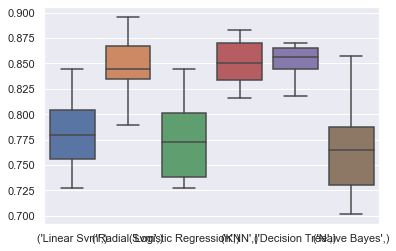

In [52]:
box=pd.DataFrame(accuracy,index=[classifiers])
sns.boxplot(data=box.T)
plt.show()
# we can see that the SVM and Logistic regression were the best algorithms for this case

### Comparation 

Let's see another machine learning models, how the perform this problem of binary classification!

#### KNN

In [53]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(x_train, y_train);

In [54]:
y_pred_knn = knn.predict(x_test)
y_pred_knn

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0],
      dtype=int64)

In [55]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
score_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

In [56]:
print("Confusion Matrix for KNN \n")
print(cm_knn)
print()
print("Report")
print(report_knn)
print()
print("Score")
print(score_knn)

Confusion Matrix for KNN 

[[89 10]
 [15 40]]

Report
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        99
           1       0.80      0.73      0.76        55

    accuracy                           0.84       154
   macro avg       0.83      0.81      0.82       154
weighted avg       0.84      0.84      0.84       154


Score
0.8376623376623377


In [57]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [58]:
y_pred_tree = clf.predict(x_test)

In [59]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
score_tree = accuracy_score(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree)

In [60]:
print("Confusion Matrix for Decision Tree \n")
print(cm_tree)
print()
print("Report")
print(report_tree)
print()
print("Score")
print(score_tree)

Confusion Matrix for Decision Tree 

[[85 14]
 [12 43]]

Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        99
           1       0.75      0.78      0.77        55

    accuracy                           0.83       154
   macro avg       0.82      0.82      0.82       154
weighted avg       0.83      0.83      0.83       154


Score
0.8311688311688312


In [61]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train, y_train)

SVC()

In [62]:
y_pred_svm = clf.predict(x_test)

In [63]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
score_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)


In [64]:
print("Confusion Matrix for SVM \n")
print(cm_svm)
print()
print("Report")
print(report_svm)
print()
print("Score")
print(score_svm)

Confusion Matrix for SVM 

[[93  6]
 [15 40]]

Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        99
           1       0.87      0.73      0.79        55

    accuracy                           0.86       154
   macro avg       0.87      0.83      0.85       154
weighted avg       0.86      0.86      0.86       154


Score
0.8636363636363636


## Loading our model files

In [65]:
diabetes_model = tf.keras.models.load_model("./diabetes_deep_learning_model.hd5")
sc = joblib.load("./std_scaler.bin")


## Predicting new patient!

In [66]:
new_pred = knn.predict(
    sc.transform(
        np.array(
            [[3, 180.0, 90, 35, 0, 33.6, 0.627, 50.0]]
        )
    )
)
new_pred.item()

0

In [67]:
new_prediction = diabetes_model.predict(
    sc.transform(
        np.array(
            [[3, 180.0, 90, 35, 0, 33.6, 0.627, 50.0]]
        )
    )
)


In [68]:
new_prediction.item()


0.03142213821411133

This patient has a probability of 86.71% is diabetic !

# Approach 2 - Feature Engineering 
First, let's separate our dataframe into x and y

In [69]:
x2 = df.iloc[:, 0:8]
y2 = df.iloc[:, -1]

### Insulin: Normal and unsual levels of insulin.
using the following [article](https://www.newhealthadvisor.org/Normal-Insulin-Levels.html), normal levels of insulin (2h serum) should be between 16-166 mlU/L. So let's create a feature that uses this values

In [70]:
# we will use 1 for normal and 0 for abnormal
x2.loc[:, 'Insulin_lvl'] = 0
x2.loc[(x2['Insulin'] >= 16) & (x2['Insulin'] <= 166), 'Insulin_lvl'] = 1
x2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_lvl
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,0
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,1
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,0
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,1
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,1
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,0


In [71]:
# helper function to visualize correlation between variables
def plot_f1_f2(f1, f2) :  
    D = df[(df['Outcome'] != 0)]
    H = df[(df['Outcome'] == 0)]

    plot1 = go.Scatter(x = D[f1], y = D[f2], name = 'diabetic', mode = 'markers', marker = dict(color = '#FFD700', line = dict(width = 1)))
    plot2 = go.Scatter(x = H[f1],y = H[f2],name = 'healthy',mode = 'markers',marker = dict(color = '#7EC0EE',line = dict(width = 1)))

    layout = dict(title = f1 +" "+"vs"+" "+ f2, yaxis = dict(title = f2,zeroline = False), xaxis = dict(title = f1, zeroline = False))

    plots = [plot1, plot2]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

Let's look again into the correlation matrix

<AxesSubplot:>

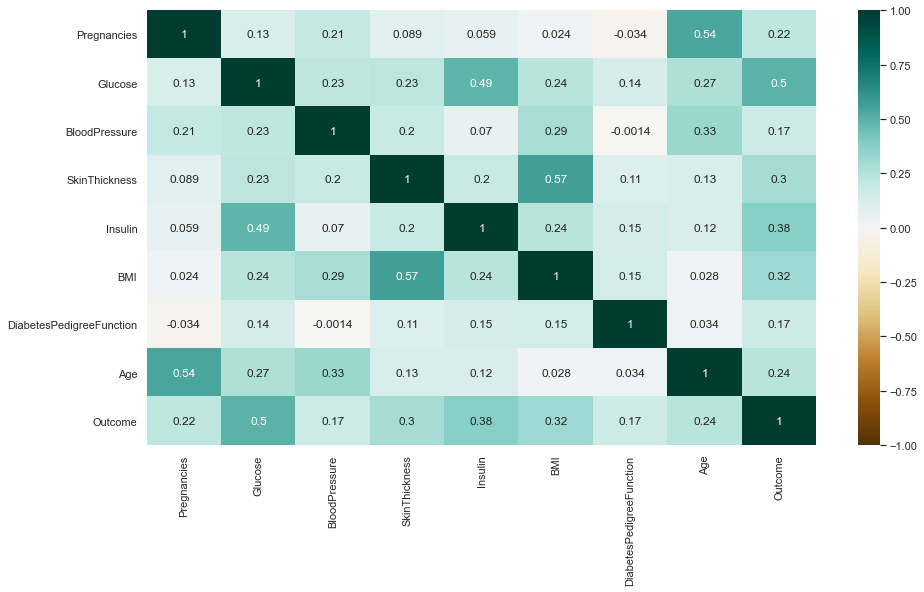

In [72]:
plt.subplots(figsize=(15, 8))

sns.heatmap(df.corr(), annot=True, cmap='BrBG', vmin=-1, vmax=1)

We can see that we have a few "strong" correlations
- Pregnancies and Age `.54`
- Glucose and Insulin `.49`
- SkinThickness and BMI `.57`

Let's Plot this features together and see what happens

### Pregnacies vs Age

In [73]:
plot_f1_f2('Pregnancies', 'Age')

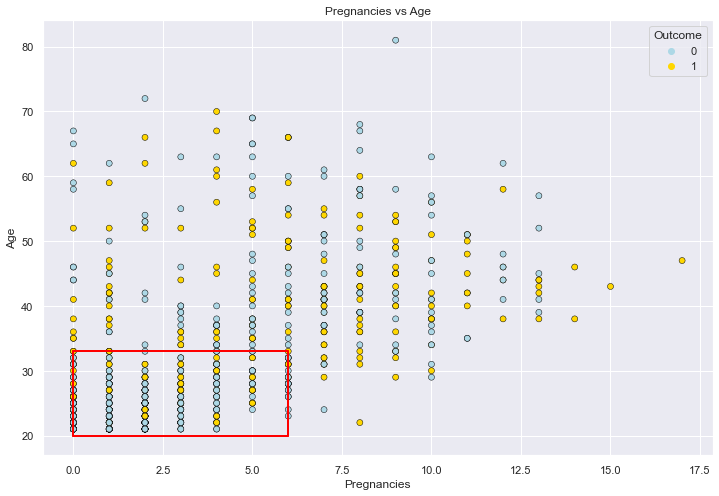

In [74]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = df['Pregnancies'], y = df['Age'], hue = "Outcome",
                    data = df, palette = palette, edgecolor=edgecolor)

plt.plot([0, 6], [33, 33], linewidth=2, color = 'red')
plt.plot([6, 6], [20, 33], linewidth=2, color = 'red')
plt.plot([0, 6], [20, 20], linewidth=2, color = 'red')
plt.plot([0, 0], [20, 33], linewidth=2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

We see a concentration of healthy people between 0 to 6 pregnacies and with age <= 30. Let's use this information to create a new feature where anything between the range will be 1 (healthy) and anything outside is 0 (unhealthy). We will do the same for the remaining strong corrilations

In [75]:
x2.loc[:,'Preg_age']=0
x2.loc[(x2['Age']<=30) & (x2['Pregnancies']<=6),'Preg_age']=1
x2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_lvl,Preg_age
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,0,0
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,1,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,1,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,0,0
...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,1,1
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,1,1
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,0,0


### Glucose vs Insulin

In [76]:
plot_f1_f2('Glucose', 'Insulin')

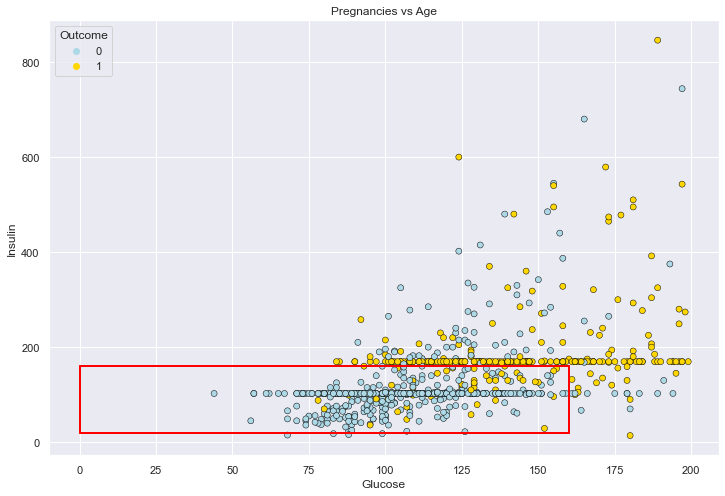

In [77]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = df['Glucose'], y = df['Insulin'], hue = "Outcome",
                    data = df, palette = palette, edgecolor=edgecolor)

plt.plot([0, 160], [160, 160], linewidth=2, color = 'red')
plt.plot([160, 160], [20, 160], linewidth=2, color = 'red')
plt.plot([0, 160], [20, 20], linewidth=2, color = 'red')
plt.plot([0, 0], [20, 160], linewidth=2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

Same as before, we can see a stron concentration of healthy people in Glucose <= 160 and Insulin <= 160.

In [78]:
x2.loc[:,'gluc_insulin']=0
x2.loc[(x2['Glucose']<=160) & (x2['Insulin']<=160),'gluc_insulin']=1

### SkinThickness vs BMI

In [79]:
plot_f1_f2('SkinThickness', 'BMI')

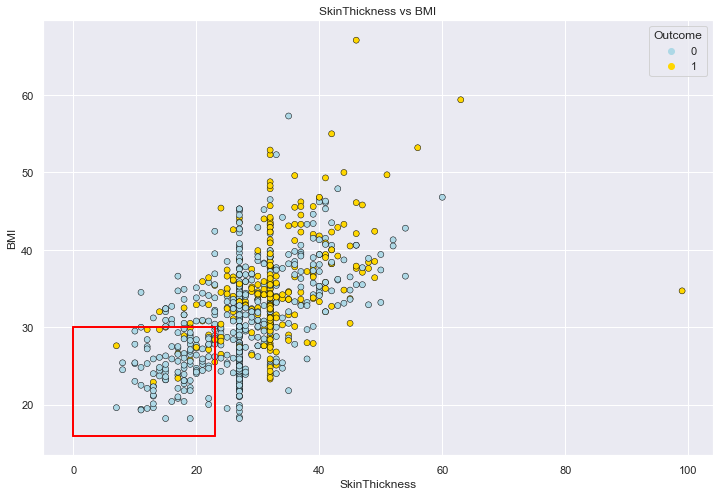

In [80]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = df['SkinThickness'], y = df['BMI'], hue = "Outcome",
                    data = df, palette = palette, edgecolor=edgecolor)

plt.plot([0, 23], [30, 30], linewidth=2, color = 'red')
plt.plot([0, 0], [16, 30], linewidth=2, color = 'red')
plt.plot([0, 23], [16, 16], linewidth=2, color = 'red')
plt.plot([23, 23], [16, 30], linewidth=2, color = 'red')
plt.title('SkinThickness vs BMI')
plt.show()

For this case we are taking values between BMI <= 30 and SkinThickness <= 23.

In [81]:
x2.loc[:,'SkinT_bmi']=0
x2.loc[(x2['BMI']<30) & (x2['SkinThickness']<=23),'SkinT_bmi']=1

### BMI
[Resource](https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html)

Body mass index, or BMI, is a way to help you figure out if you are at a healthy weight for your height. BMI is a number based on your weight and height. In general, the higher the number, the more body fat a person has. BMI is often used as a screening tool to decide if your weight might be putting you at risk for health problems such as heart disease, diabetes, and cancer.

BMI is used to broadly define different weight groups in adults 20 years old or older. The same groups apply to both men and women.

Underweight: BMI is less than 18.5
Normal weight: BMI is 18.5 to 24.9
Overweight: BMI is 25 to 29.9
Obese: BMI is 30 or more

we can use 30kg/m2 to set our limit, so let's assume that if BMI <= 30 the person is healthy (1) and otherwise is diabetic (0)

In [82]:
x2.loc[:,'BMI_limit']=0
x2.loc[(x2['BMI']<=30),'BMI_limit']=1
x2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_lvl,Preg_age,gluc_insulin,SkinT_bmi,BMI_limit
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,0,0,0,0,0
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,1,0,1,0,1
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,0,0,0,0,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,1,1,1,1,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,0,0,0,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,1,1,1,0,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,1,1,1,1,1
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,0,0,0,0,0


## Prepering for training

In [83]:
x2_values = x2.values
y2_values = y2.values

In [84]:
pd.DataFrame(x2_values).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,0.0,0.0,0.0,0.0,0.0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,1.0,0.0,1.0,0.0,1.0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,0.0,0.0,0.0,0.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,1.0,1.0,1.0,1.0,1.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,0.0,0.0,0.0,0.0,0.0


In [85]:
pd.DataFrame(y2_values).head()

,0
0,1
1,0
2,1
3,0
4,1


In [86]:
#Splitting the date
x2_train, x2_test, y2_train, y2_test = train_test_split(x2_values, y2_values, test_size=0.2, random_state=1)

## Standarize

In [87]:
# Feature Scaling

sc = StandardScaler()
x2_train = sc.fit_transform(x2_train)
x2_test = sc.transform(x2_test)

pd.DataFrame(x2_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.516591,0.761557,0.621981,1.975874,-0.134534,0.837518,0.529526,0.567932,0.741960,-1.09218,0.801069,-0.433152,-0.795600
1,1.812018,0.236795,-0.827800,0.825607,0.303844,1.321483,-0.069689,0.398450,-1.347781,-1.09218,-1.248332,-0.433152,-0.795600
2,0.925736,-0.648741,0.138721,1.285714,-0.411988,0.734858,-0.794249,0.991638,0.741960,-1.09218,0.801069,-0.433152,-0.795600
3,1.221164,-0.058384,0.460894,-0.209633,-0.439733,-1.054349,-0.167519,2.601722,0.741960,-1.09218,0.801069,-0.433152,1.256914
4,-0.551400,-0.058384,0.299808,0.940634,-0.411988,1.101499,-0.760619,-0.364222,0.741960,0.91560,0.801069,-0.433152,-0.795600


## Machine Learning

### Neural Networks

In [88]:
# Set initial seed
tf.random.set_seed(42)

# Tensorflow Neuronal Network

units = 35 # 13 * 2 / 3 + 2
LR = 1e-3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: LR*10**(epoch/40))


# Initializing ANN
classifier = Sequential([
    tf.keras.layers.Dense(units,activation=tf.keras.activations.relu),
    # tf.keras.layers.Dense(units,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid),
])

classifier.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="Accuracy"),
    ]
)

# history = classifier.fit(x2_train, y2_train, epochs=150, validation_data=(x2_test, y2_test), callbacks=[lr_schedule])
history = classifier.fit(x2_train, y2_train, epochs=350, validation_data=(x2_test, y2_test))


Epoch 1/350
20/20 [==============================] - 1s 17ms/step - loss: 0.7075 - Accuracy: 0.5358 - val_loss: 0.6455 - val_Accuracy: 0.5909
Epoch 2/350
20/20 [==============================] - 0s 5ms/step - loss: 0.6309 - Accuracy: 0.6792 - val_loss: 0.5889 - val_Accuracy: 0.6948
Epoch 3/350
20/20 [==============================] - 0s 3ms/step - loss: 0.5783 - Accuracy: 0.7769 - val_loss: 0.5454 - val_Accuracy: 0.7792
Epoch 4/350
20/20 [==============================] - 0s 2ms/step - loss: 0.5374 - Accuracy: 0.8094 - val_loss: 0.5147 - val_Accuracy: 0.8247
Epoch 5/350
20/20 [==============================] - 0s 2ms/step - loss: 0.5083 - Accuracy: 0.8257 - val_loss: 0.4911 - val_Accuracy: 0.8506
Epoch 6/350
20/20 [==============================] - 0s 3ms/step - loss: 0.4858 - Accuracy: 0.8420 - val_loss: 0.4716 - val_Accuracy: 0.8506
Epoch 7/350
20/20 [==============================] - 0s 6ms/step - loss: 0.4676 - Accuracy: 0.8404 - val_loss: 0.4557 - val_Accuracy: 0.8571
Epoch 8/350


Text(0, 0.5, 'Loss')

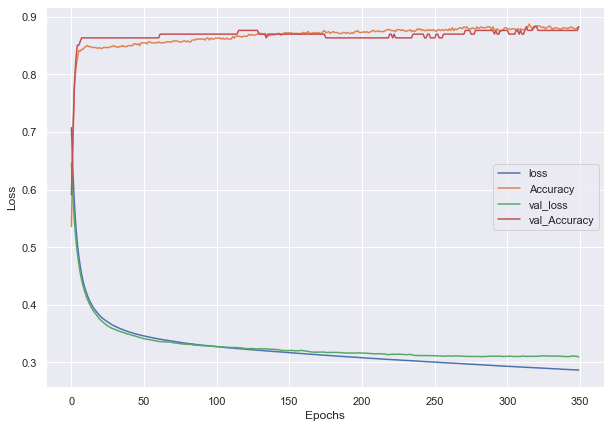

In [89]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('Epochs')
plt.ylabel('Loss')


In [90]:
y_pred_nn = classifier.predict(x2_test)
y_pred_nn = (y_pred_nn > 0.5)

In [91]:
y_pred_nn

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [

In [92]:
cm_nn = confusion_matrix(y2_test, y_pred_nn)

score_nn = accuracy_score(y2_test, y_pred_nn)
report_nn = classification_report(y2_test, y_pred_nn)

In [93]:
print("Confusion Matrix for our NN \n")
print(cm_nn)
print()
print("Report")
print(report_nn)
print()
print("Score")
print(score_nn)

Confusion Matrix for our NN 

[[92  7]
 [11 44]]

Report
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        99
           1       0.86      0.80      0.83        55

    accuracy                           0.88       154
   macro avg       0.88      0.86      0.87       154
weighted avg       0.88      0.88      0.88       154


Score
0.8831168831168831


In [94]:
# Saving our second model
classifier.save("./diabetes_deep_learning_model_approach2.hd5")
joblib.dump(sc, "./std_scaler2.bin", compress=True)

INFO:tensorflow:Assets written to: ./diabetes_deep_learning_model_approach2.hd5\assets


['./std_scaler2.bin']

### Cross Validation

With this new approach we will also do a Cross-Validation againt other algorithms

In [95]:
xyz=[]
accuracy=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree', 'Naive Bayes', 'NN']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(max_iter=300),KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(), GaussianNB()]
for i in models:
    model = i
    cv_result = cross_val_score(model,x2_train, y2_train, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    accuracy.append(cv_result)
xyz.append(score_nn)
new_models_dataframe2=pd.DataFrame(xyz,index=classifiers)
new_models_dataframe2.columns=['CV Mean']    

In [96]:
new_models_dataframe2.sort_values(by="CV Mean", ascending=False)

,CV Mean
NN,0.883117
Radial Svm,0.848519
Naive Bayes,0.847012
Linear Svm,0.840534
Logistic Regression,0.838842
Decision Tree,0.833871
KNN,0.832364


## First approach with new architecture

In [97]:
# Tensorflow Neuronal Network

# # Set initial seed
tf.random.set_seed(42)

units = 8 # 8 * 2 / 3 + 2
drop = 0.3

# Initializing ANN
classifier = Sequential([
    tf.keras.layers.Dense(units,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid),
])

classifier.compile(
    optimizer=tf.keras.optimizers.Adamax(),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(), 
    ]
)

history = classifier.fit(x_train, y_train, epochs=350, validation_data=(x_test, y_test))

Epoch 1/350
20/20 [==============================] - 1s 12ms/step - loss: 0.6943 - binary_accuracy: 0.6482 - val_loss: 0.6757 - val_binary_accuracy: 0.6558
Epoch 2/350
20/20 [==============================] - 0s 4ms/step - loss: 0.6726 - binary_accuracy: 0.6498 - val_loss: 0.6577 - val_binary_accuracy: 0.6623
Epoch 3/350
20/20 [==============================] - 0s 4ms/step - loss: 0.6573 - binary_accuracy: 0.6498 - val_loss: 0.6420 - val_binary_accuracy: 0.6688
Epoch 4/350
20/20 [==============================] - 0s 4ms/step - loss: 0.6430 - binary_accuracy: 0.6580 - val_loss: 0.6282 - val_binary_accuracy: 0.6753
Epoch 5/350
20/20 [==============================] - 0s 4ms/step - loss: 0.6309 - binary_accuracy: 0.6612 - val_loss: 0.6160 - val_binary_accuracy: 0.6818
Epoch 6/350
20/20 [==============================] - 0s 6ms/step - loss: 0.6195 - binary_accuracy: 0.6612 - val_loss: 0.6042 - val_binary_accuracy: 0.6883
Epoch 7/350
20/20 [==============================] - 0s 9ms/step - lo

Text(0, 0.5, 'Loss')

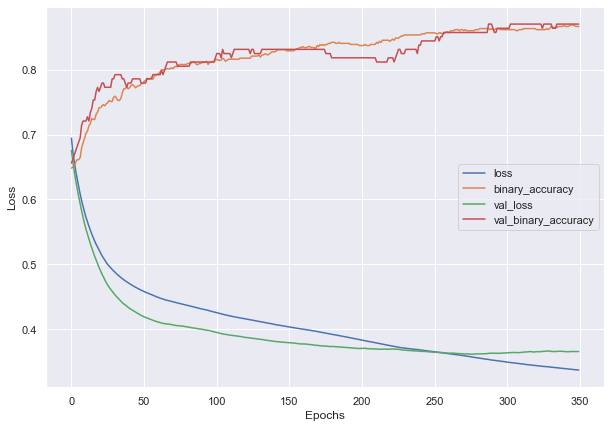

In [98]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [99]:
y_pred = classifier.predict(x_test)
y_pred = tf.round(y_pred)

In [100]:
cm = confusion_matrix(y_test, y_pred)

score = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [101]:
print("Confusion Matrix for our NN \n")
print(cm)
print()
print("Report")
print(report)
print()
print("Score")
print(score)

Confusion Matrix for our NN 

[[89 10]
 [10 45]]

Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        99
           1       0.82      0.82      0.82        55

    accuracy                           0.87       154
   macro avg       0.86      0.86      0.86       154
weighted avg       0.87      0.87      0.87       154


Score
0.8701298701298701


# Conclusion

* We achieve a 88% accuracy with the new NN architecture which means almost 10% improvement of the initial approach.
* For future work other features like gender could also help improve the accuracy.
* A larger dataset might be helpful to improve training accuracy.
